### noisy hallway environment

Falling back to num_samples=4
Falling back to num_samples=4


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


[2, 0, 1]
-90.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Discrete(5)
[2.  0.  1.4]
-90.0
[2.  0.  1.4]
-90.0
[2.  0.  1.4]
-90.0
[2.  0.  1.4]
-90.0
[2.  0.  1.4]
-90.0
[2.  0.  1.4]
-85.0
[2.0348623  0.         1.79847788]
-85.0
[2.0348623  0.         1.79847788]
-80.00000000000001
[2.0348623  0.         1.79847788]
-75.00000000000001
[1.93133468 0.         1.41210755]
-75.00000000000001
[1.82780706 0.         1.02573722]
-75.00000000000001


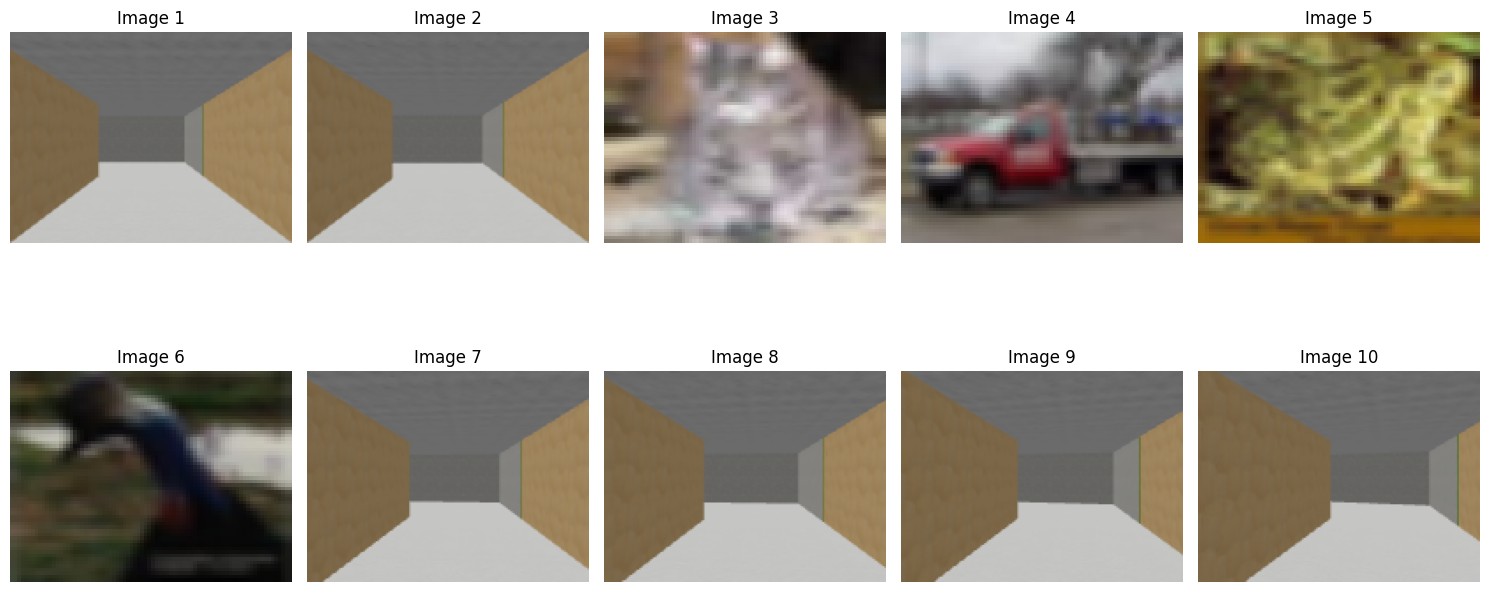

In [ ]:
import math
import random
import numpy as np

import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
# from torchvision import transforms

from gymnasium import spaces, utils
from gymnasium.envs.registration import register

from miniworld.entity import TextFrame, Box
from miniworld.miniworld import MiniWorldEnv
from PIL import Image

def load_cifar_dataset():
    """
    Load the CIFAR-10 dataset.

    Returns:
        cifar_dataset: The loaded CIFAR-10 dataset
    """
    # Define transform
    transform = transforms.Compose([transforms.ToTensor()])

    # Download dataset if not already downloaded
    cifar_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    return cifar_dataset

class MazeEnv(MiniWorldEnv, utils.EzPickle):

    def __init__(self, goal_pos=None, **kwargs):
        self.visited_states = np.zeros((18 * 4, 12 * 4))
        self.goal_pos = goal_pos

        MiniWorldEnv.__init__(self, max_episode_steps=50000, **kwargs)
        utils.EzPickle.__init__(self, goal_pos, **kwargs)
        self.action_space = spaces.Discrete(self.actions.move_forward + 3)
        self.cifar_dataset = load_cifar_dataset()
        self.prev_action = None


    def replace_green_with_random(self, observation):
        modified_obs = observation.copy()

        green_mask = (
            (observation[:, :, 0] < 800) &  # Low red
            (observation[:, :, 1] > 80) &  # High green
            (observation[:, :, 2] < 50)    # Low blue
        )

        # Get coordinates of green pixels
        green_coords = np.where(green_mask)

        # Replace each green pixel with a random color
        for i in range(len(green_coords[0])):
            y, x = green_coords[0][i], green_coords[1][i]
            # Generate random RGB values
            random_color = [
                random.randint(0, 255),  # Random red
                random.randint(0, 255),  # Random green
                random.randint(0, 255)   # Random blue
            ]
            modified_obs[y, x] = random_color

        return modified_obs


    def _gen_world(self):

        room1 = self.add_rect_room(min_x=0, max_x=4, min_z=0, max_z=8, wall_tex='cardboard', floor_tex="stucco")
        room2 = self.add_rect_room(min_x=14, max_x=18, min_z=0, max_z=8, wall_tex='asphalt', floor_tex="stucco")

        room3 = self.add_rect_room(min_x=0, max_x=18, min_z=8, max_z=8.1, wall_tex='grass', floor_tex="stucco") # noise wall on r3
        room4 = self.add_rect_room(min_x=0, max_x=18, min_z=8.1, max_z=12, floor_tex="stucco")

        self.connect_rooms(room1, room3, min_x=0, max_x=4)
        self.connect_rooms(room2, room3, min_x = 14, max_x = 18)
        # self.connect_rooms(room1, room4, min_z=8.1, max_z=12)
        self.connect_rooms(room3, room4, min_x=0, max_x=18)
        # self.connect_rooms(room1, room2, min_z=-2, max_z=2)

        # Choose a random room and position to spawn at
        self.place_agent(
            pos=[2, 0, 1], dir=-math.pi/2, room=room1
        )

    def generate_random_cifar_observation(self, cifar_dataset, width, height):
        """
        Generate a random observation from CIFAR-10 dataset with the specified dimensions.
        The function stretches the image to fill the observation space.

        Args:
            cifar_dataset: The CIFAR-10 dataset
            width: Width of the observation
            height: Height of the observation

        Returns:
            observation: numpy array with shape (height, width, 3)
        """
        # Select a random image
        random_index = random.randint(0, len(cifar_dataset) - 1)
        image, _ = cifar_dataset[random_index]

        # Convert tensor to PIL Image
        image_np = image.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC
        pil_image = Image.fromarray((image_np * 255).astype(np.uint8))

        # Stretch the image to the desired dimensions
        stretched_image = pil_image.resize((width, height), Image.Resampling.BILINEAR)

        # Convert to numpy array format
        observation = np.array(stretched_image)

        return observation



    # redefine action
    def step(self, action):
        fwd_step = 0.4
        fwd_drift = 0
        turn_step = 5
        self.step_count += 1
        if self.prev_action is not None and random.random() < 0.25:
            action = self.prev_action
        self.prev_action = action
        if action == 4:
            # return self.last_obs, self.last_reward, self.last_terminated, self.last_truncated, self.last_info
            # print("noise image")
            obs = obs = self.generate_random_cifar_observation(self.cifar_dataset, 80, 60)
            reward = 0
            termination = False
            truncation = False
            info = {}
            return obs, reward, termination, truncation, info

        # move forward means: move 0.25 toward pos 0
        if action == self.actions.move_forward:
            # self.agent.dir = 0
            self.move_agent(fwd_step, fwd_drift)

        elif action == self.actions.move_back:
            # self.agent.dir = math.pi
            self.move_agent(-fwd_step, fwd_drift)

        elif action == self.actions.turn_left:
            # self.agent.dir = math.pi / 2
            # self.move_agent(fwd_step, fwd_drift)
            self.turn_agent(turn_step)

        elif action == self.actions.turn_right:
            # self.agent.dir = -math.pi/2
            # self.move_agent(fwd_step, fwd_drift)
            self.turn_agent(-turn_step)

        obs = self.render_obs()
        reward = 0
        termination = False
        truncation = False
        info = {}
        agent_x = self.agent.pos[0]
        agent_z = self.agent.pos[2]
        self.visited_states[int(agent_x * 4), int(agent_z * 4)] = 1
        info["visited_state"] = np.sum(self.visited_states, dtype = np.uint8)
        info["pos"] = [self.agent.pos[0], self.agent.pos[2]]
        info["dir"] = self.agent.dir

        return self.replace_green_with_random(obs), reward, termination, truncation, info


env = MazeEnv(render_mode=None, obs_width=160, obs_height=120)
dataset = []
# env.reset()
env.render_top_view()
print(env.agent.pos)
print(math.degrees(env.agent.dir))
print(env.visited_states)
print(env.action_space)
obs = env.render_obs()
for i in range(11):
    dataset.append(obs)
    obs, reward, termination, truncation, info = env.step(env.action_space.sample())
    print(env.agent.pos)
    print(math.degrees(env.agent.dir))
dataset.append(obs)
plt.figure(figsize=(15, 8))

for i in range(10):  # Show first 10 images
    # Get the observation image at index 4
    image = dataset[i]

    # Create subplot
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()
env.close()

# LPM

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym
import random
import matplotlib.pyplot as plt
import pickle
import os
import math
import imageio

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNNFeatureExtractor(nn.Module):
    def __init__(self, input_shape):
        super(CNNFeatureExtractor, self).__init__()

        # Input shape: (channels, height, width)
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Calculate size after convolutions
        def conv2d_size_out(size, kernel_size, stride):
            return (size - kernel_size) // stride + 1

        conv_width = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[2], 8, 4), 4, 2), 3, 1)
        conv_height = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[1], 8, 4), 4, 2), 3, 1)
        self.feature_size = conv_width * conv_height * 64

    def forward(self, x):
        # Preprocess image
        x = x / 255.0  # Normalize pixel values
        x = x.permute(0, 3, 1, 2)  # Change from (N, H, W, C) to (N, C, H, W)

        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view

        return x

class MSEPredictionModel(nn.Module):
    """Primary network for predicting the next state using MSE loss"""
    def __init__(self, input_shape, num_actions):
        super(MSEPredictionModel, self).__init__()

        # Store input shape
        self.input_shape = input_shape  # (channels, height, width)
        self.height = input_shape[1]
        self.width = input_shape[2]
        self.channels = input_shape[0]
        self.num_actions = num_actions

        # Feature extractor
        self.feature_extractor = CNNFeatureExtractor(input_shape)
        feature_size = self.feature_extractor.feature_size

        # Forward model to combine state features and action
        self.forward_model = nn.Sequential(
            nn.Linear(feature_size + num_actions, 512),
            nn.ReLU()
        )

        # Decoder to predict next state
        h_out = self.height // 8  # Estimate based on typical CNN feature size reduction
        w_out = self.width // 8

        self.decoder = nn.Sequential(
            nn.Linear(512, h_out * w_out * 64),
            nn.ReLU(),
            nn.Unflatten(1, (64, h_out, w_out)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, self.channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),  # Output in range [0,1]
            nn.Upsample(size=(self.height, self.width), mode='bilinear', align_corners=False)
        )

        # Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def forward(self, state, action):
        """Forward pass to predict next state"""
        # Extract features
        state_features = self.feature_extractor(state)

        # Create one-hot encoding of action
        action_one_hot = F.one_hot(action, num_classes=self.num_actions).float()

        # Combine features and action
        combined = torch.cat([state_features, action_one_hot], dim=1)
        features = self.forward_model(combined)

        # Predict next state
        predicted_next_state = self.decoder(features)

        return predicted_next_state

    def update(self, states, next_states, actions):
        """Update the prediction model using MSE loss"""
        # Forward pass
        predicted_next_states = self.forward(states, actions)

        # Target state (normalized to match prediction format)
        target_next_states = next_states.permute(0, 3, 1, 2) / 255.0

        # Compute MSE loss
        loss = F.mse_loss(predicted_next_states, target_next_states)

        # Backward pass and optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def compute_error(self, state, next_state, action):
        """Compute prediction error for a given state-action-next_state triplet"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        action_tensor = torch.LongTensor([action]).to(device)

        with torch.no_grad():
            # Get prediction
            predicted_next_state = self.forward(state_tensor, action_tensor)

            # Convert target to match prediction format
            next_state_tensor_permuted = next_state_tensor.permute(0, 3, 1, 2) / 255.0

            # Calculate squared error - per element
            squared_error = torch.pow(next_state_tensor_permuted - predicted_next_state, 2)

            # Mean over all dimensions to get scalar error
            mse = squared_error.mean().item()

        return mse

class UncertaintyPredictionModel(nn.Module):
    """Separate network for predicting expected prediction errors"""
    def __init__(self, input_shape, num_actions):
        super(UncertaintyPredictionModel, self).__init__()

        # Feature extractor (same architecture as main model)
        self.feature_extractor = CNNFeatureExtractor(input_shape)
        feature_size = self.feature_extractor.feature_size
        self.num_actions = num_actions

        # Network to predict log of expected error
        self.uncertainty_net = nn.Sequential(
            nn.Linear(feature_size + num_actions, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Predict a single scalar - log of expected MSE
        )

        # Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=0.01)  # Higher learning rate as it's a simpler task

    def forward(self, state, action):
        """Forward pass to predict log of expected prediction error"""
        # Extract features
        state_features = self.feature_extractor(state)

        # Create one-hot encoding of action
        action_one_hot = F.one_hot(action, num_classes=self.num_actions).float()

        # Combine features and action
        combined = torch.cat([state_features, action_one_hot], dim=1)

        # Predict log uncertainty
        log_uncertainty = self.uncertainty_net(combined)

        # Clamp to avoid numerical issues
        log_uncertainty = torch.clamp(log_uncertainty, min=-10.0, max=10.0)

        return log_uncertainty

    def update(self, states, actions, actual_errors):
        """Update uncertainty predictor to better predict errors"""
        # Forward pass
        log_predicted_errors = self.forward(states, actions)

        # Convert actual errors to tensor and add epsilon to avoid log(0)
        epsilon = 1e-6
        log_actual_errors = torch.log(torch.FloatTensor(actual_errors).to(device) + epsilon).unsqueeze(1)

        # Compute MSE loss between log errors
        loss = F.mse_loss(log_predicted_errors, log_actual_errors)

        # Backward pass and optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

class LearningProgressCuriosity:
    """Combined model that measures curiosity as improvement over expected error"""
    def __init__(self, input_shape, num_actions, eta=1.0, uncertainty_buffer_size=100,
                 update_uncertainty_every=5):

        self.input_shape = input_shape
        self.num_actions = num_actions
        self.eta = eta  # Weighting for uncertainty-adjusted reward

        # Main prediction model
        self.prediction_model = MSEPredictionModel(input_shape, num_actions).to(device)

        # Uncertainty prediction model
        self.uncertainty_model = UncertaintyPredictionModel(input_shape, num_actions).to(device)

        # Buffer for storing recent prediction errors
        self.error_buffer = []
        self.buffer_size = uncertainty_buffer_size

        # Update frequency for uncertainty model
        self.update_uncertainty_every = update_uncertainty_every
        self.steps_since_uncertainty_update = 0

    def get_intrinsic_reward(self, state, next_state, action):
        """Calculate intrinsic reward based on improvement over expected error"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_tensor = torch.LongTensor([action]).to(device)

        # Get actual MSE for this transition
        actual_mse = self.prediction_model.compute_error(state, next_state, action)

        # Add error to buffer for later uncertainty training
        self.error_buffer.append((state, action, actual_mse))
        if len(self.error_buffer) > self.buffer_size:
            self.error_buffer.pop(0)

        with torch.no_grad():
            # Predict log of expected error
            log_expected_error = self.uncertainty_model(state_tensor, action_tensor)

            # Convert to expected error
            expected_error = torch.exp(log_expected_error).item()

            # Calculate improvement-based reward:
            # Positive when actual error is less than expected (improvement)
            # Negative when actual error is more than expected (getting worse)
            intrinsic_reward = self.eta * expected_error - actual_mse

            # Clip to not exceed 1 (rather than clipping to be non-negative)
            intrinsic_reward = min(0.5, intrinsic_reward)

        return intrinsic_reward

    def update(self, states, next_states, actions):
        """Update both models"""
        # Always update prediction model
        pred_loss = self.prediction_model.update(states, next_states, actions)

        # Update uncertainty model periodically
        self.steps_since_uncertainty_update += 1
        uncertainty_loss = 0.0

        if self.steps_since_uncertainty_update >= self.update_uncertainty_every and len(self.error_buffer) > 0:
            # Sample from error buffer (up to batch_size)
            batch_size = min(32, len(self.error_buffer))
            indices = np.random.choice(len(self.error_buffer), batch_size, replace=False)

            sampled_states = []
            sampled_actions = []
            sampled_errors = []

            for idx in indices:
                state, action, error = self.error_buffer[idx]
                sampled_states.append(state)
                sampled_actions.append(action)
                sampled_errors.append(error)

            # Convert to tensors
            state_batch = torch.FloatTensor(np.array(sampled_states)).to(device)
            action_batch = torch.LongTensor(sampled_actions).to(device)

            # Update uncertainty model
            uncertainty_loss = self.uncertainty_model.update(state_batch, action_batch, sampled_errors)

            # Reset counter
            self.steps_since_uncertainty_update = 0

        return pred_loss, uncertainty_loss

class A2CNetwork(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(A2CNetwork, self).__init__()

        # Feature extractor
        self.feature_extractor = CNNFeatureExtractor(input_shape)
        feature_size = self.feature_extractor.feature_size

        # Actor (policy) and critic (value) heads
        self.fc_actor = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

        self.fc_critic = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)

        # Actor (policy) head
        action_logits = self.fc_actor(features)

        # Critic (value) head
        value = self.fc_critic(features)

        return action_logits, value

# Memory class for experience collection
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.intrinsic_rewards = []
        self.next_states = []
        self.dones = []
        self.logprobs = []
        self.values = []

    def add(self, state, action, reward, intrinsic_reward, next_state, done, logprob, value):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.intrinsic_rewards.append(intrinsic_reward)
        self.next_states.append(next_state)
        self.dones.append(done)
        self.logprobs.append(logprob)
        self.values.append(value)

    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.intrinsic_rewards.clear()
        self.next_states.clear()
        self.dones.clear()
        self.logprobs.clear()
        self.values.clear()

    def __len__(self):
        return len(self.states)

class A2CAgentWithLearningProgressCuriosity:
    def __init__(self, env, learning_rate=0.0003, gamma=0.99, gamma_intrinsic=0.99,
                 lambda_intrinsic=1.0, gae_lambda=0.95, entropy_coef=0.01,
                 value_loss_coef=0.5, max_grad_norm=0.5):

        # Environment info
        self.env = env
        self.obs_shape = env.observation_space.shape
        self.num_actions = env.action_space.n

        # Add persistent visited states tracking
        self.visited_states_grid = np.zeros((18*4, 12*4))  # Match the environment's grid size
        self.total_visited_states = 0

        # Learning Progress curiosity model
        self.curiosity = LearningProgressCuriosity(
            (self.obs_shape[2], self.obs_shape[0], self.obs_shape[1]),
            self.num_actions,
            eta=1.0,
            uncertainty_buffer_size=100,
            update_uncertainty_every=5
        )

        # Policy network
        self.policy = A2CNetwork(
            (self.obs_shape[2], self.obs_shape[0], self.obs_shape[1]),
            self.num_actions).to(device)

        # A2C uses RMSprop optimizer
        self.optimizer = optim.RMSprop(self.policy.parameters(), lr=learning_rate,
                                      alpha=0.99, eps=1e-8)

        # Hyperparameters
        self.gamma = gamma
        self.gamma_intrinsic = gamma_intrinsic
        self.lambda_intrinsic = lambda_intrinsic
        self.gae_lambda = gae_lambda
        self.entropy_coef = entropy_coef
        self.value_loss_coef = value_loss_coef
        self.max_grad_norm = max_grad_norm

        # Memory
        self.memory = Memory()

        # Training stats
        self.exploration_steps = 0
        self.first_success_step = None

    def update_visited_states(self, info):
        """
        Update our own persistent tracking of visited states
        Returns the total number of visited states so far
        """
        # Extract agent position from info if available, otherwise try to get it from environment
        if hasattr(self.env, 'agent') and hasattr(self.env.agent, 'pos'):
            agent_x = self.env.agent.pos[0]
            agent_z = self.env.agent.pos[2]

            # Convert to grid coordinates
            grid_x = int(agent_x * 4)
            grid_z = int(agent_z * 4)

            # Check bounds to prevent index errors
            if 0 <= grid_x < 18*4 and 0 <= grid_z < 12*4:
                # If this is a new state, increment counter
                if self.visited_states_grid[grid_x, grid_z] == 0:
                    self.visited_states_grid[grid_x, grid_z] = 1
                    self.total_visited_states += 1

        return self.total_visited_states

    def select_action(self, state, training=True):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

        with torch.no_grad():
            action_logits, value = self.policy(state_tensor)
            action_probs = F.softmax(action_logits, dim=-1)
            dist = Categorical(action_probs)
            action = dist.sample().item()
            logprob = dist.log_prob(torch.tensor(action).to(device)).item()
            value = value.item()

        return action, logprob, value

    def compute_gae(self, rewards, values, dones, next_value=0):
        """Compute Generalized Advantage Estimation (GAE)"""
        returns = []
        gae = 0

        for i in reversed(range(len(rewards))):
            delta = rewards[i] + self.gamma * next_value * (1 - dones[i]) - values[i]
            gae = delta + self.gamma * self.gae_lambda * (1 - dones[i]) * gae
            next_value = values[i]
            returns.insert(0, gae + values[i])

        return returns

    def update(self):
        """A2C update method"""
        # If memory is empty, nothing to update
        if len(self.memory.states) == 0:
            return 0, 0

        # Convert lists to tensors
        states = torch.FloatTensor(np.array(self.memory.states)).to(device)
        next_states = torch.FloatTensor(np.array(self.memory.next_states)).to(device)
        actions = torch.LongTensor(self.memory.actions).to(device)
        values = torch.FloatTensor(self.memory.values).to(device)
        dones = np.array(self.memory.dones)

        # Get combined rewards
        extrinsic_rewards = np.array(self.memory.rewards)
        intrinsic_rewards = np.array(self.memory.intrinsic_rewards)

        # Update curiosity model
        pred_loss, uncertainty_loss = self.curiosity.update(states, next_states, actions)

        # Combine rewards
        combined_rewards = extrinsic_rewards + (self.lambda_intrinsic * intrinsic_rewards)

        # Ensure rewards do not exceed 1 (rather than clipping to be non-negative)
        combined_rewards = np.minimum(combined_rewards, 1.0)

        # Compute returns with GAE
        with torch.no_grad():
            # Get value of the last state
            if len(self.memory.next_states) > 0:
                last_state = torch.FloatTensor(self.memory.next_states[-1]).unsqueeze(0).to(device)
                _, last_value = self.policy(last_state)
                last_value = last_value.item()
            else:
                last_value = 0

        returns = torch.FloatTensor(self.compute_gae(combined_rewards, self.memory.values, dones, last_value)).to(device)

        # Normalize returns
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Calculate updated policy and value
        action_logits, state_values = self.policy(states)
        action_probs = F.softmax(action_logits, dim=-1)
        dist = Categorical(action_probs)

        # Calculate advantage
        advantages = returns - state_values.squeeze()

        # Calculate policy loss
        policy_loss = -(dist.log_prob(actions) * advantages.detach()).mean()

        # Calculate value loss
        value_loss = F.mse_loss(state_values.squeeze(), returns)

        # Calculate entropy for exploration
        entropy = dist.entropy().mean()

        # Total loss (A2C style)
        loss = policy_loss + self.value_loss_coef * value_loss - self.entropy_coef * entropy

        # Update policy
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
        self.optimizer.step()

        # Clear memory
        self.memory.clear()

        return pred_loss, uncertainty_loss

    def train(self, max_exploration_steps=10000, update_frequency=512, log_frequency=500,
              save_frequency=1000, frame_capture_frequency=20):
        """
        Train with a single continuous exploration without episodic resets.
        Continue exploring for the full number of steps, even if goal is found.

        Args:
            max_exploration_steps: Maximum number of steps to explore
            update_frequency: How often to update the policy
            log_frequency: How often to log progress
            save_frequency: How often to save the model
            frame_capture_frequency: How often to capture frames for the GIF (every N steps)

        Returns:
            total_reward: Total reward accumulated
            first_success_step: Step at which first success occurred
            visited_states: List of visited states over time
            frames: List of frames for creating a GIF
            steps_record: List of step numbers for plotting
            cumulative_intrinsic_rewards: List of cumulative intrinsic rewards for plotting
        """
        # Initialize environment once
        state, info = self.env.reset()

        # Initialize visited states tracking with the first state
        self.update_visited_states(info)
        visited_states = [self.total_visited_states]  # Use our counter instead of info["visited_state"]

        # For visualization - collect frames for GIF
        frames = []
        # Capture initial frame
        frames.append(self.env.render_top_view())

        # Training statistics
        total_reward = 0
        total_intrinsic_reward = 0
        intrinsic_rewards_history = []
        cumulative_intrinsic_rewards = [0]  # Start with 0
        steps_record = [0]  # Record steps for plotting
        timesteps_since_update = 0
        success_reached = False

        # Single exploration loop
        for step in range(1, max_exploration_steps + 1):
            # Select action
            action, logprob, value = self.select_action(state)
            if step % 100 == 0:  # Log every 100 steps
                prob_percentage = math.exp(logprob) * 100  # Convert from log probability to percentage
                print(f"action {action}, Action probability: {prob_percentage:.2f}%")

            # Take action
            next_state, reward, termination, truncation, info = self.env.step(action)
            done = termination or truncation

            # Track visited states using our own method
            current_visited = self.update_visited_states(info)
            visited_states.append(current_visited)

            # Capture frame for GIF every N steps
            if step % frame_capture_frequency == 0:
                frames.append(self.env.render_top_view())

            # Compute intrinsic reward using learning progress
            intrinsic_reward = self.curiosity.get_intrinsic_reward(state, next_state, action)
            intrinsic_rewards_history.append(intrinsic_reward)

            # Track cumulative intrinsic reward for plotting
            total_intrinsic_reward += intrinsic_reward
            cumulative_intrinsic_rewards.append(total_intrinsic_reward)
            steps_record.append(step)

            # Store in memory
            self.memory.add(state, action, reward, intrinsic_reward, next_state, done, logprob, value)

            # Update state
            state = next_state
            total_reward += reward + intrinsic_reward
            timesteps_since_update += 1
            self.exploration_steps += 1

            if step % log_frequency == 0:
                print(f"Step {step}, intrinsic reward: {intrinsic_reward:.4f}, cumulative: {total_intrinsic_reward:.4f}")

            # Check if goal reached for the first time
            if reward > 0 and not success_reached:
                success_reached = True
                self.first_success_step = step
                print(f"First success at step {self.first_success_step}")
                # But continue exploring rather than stopping

            # Update policy if enough timesteps have elapsed
            if timesteps_since_update >= update_frequency:
                pred_loss, uncertainty_loss = self.update()
                timesteps_since_update = 0
                print(f"Step {step}, Visited states: {current_visited}, Pred Loss: {pred_loss:.4f}, Uncertainty Loss: {uncertainty_loss:.4f}")
                # Capture frame after each policy update
                frames.append(self.env.render_top_view())

            # Save model periodically
            if step % save_frequency == 0:
                self.save(f"a2c_lp_curiosity_model_step_{step}.pt")

            # If environment terminated, reset it
            if done:
                print(f"Environment terminated at step {step}, resetting...")
                state, info = self.env.reset()
                # Capture frame after reset
                frames.append(self.env.render_top_view())

        # Capture final frame
        frames.append(self.env.render_top_view())

        return total_reward, self.first_success_step, visited_states, frames, steps_record, cumulative_intrinsic_rewards

    def save(self, filename):
        torch.save({
            'policy_state_dict': self.policy.state_dict(),
            'curiosity_prediction_state_dict': self.curiosity.prediction_model.state_dict(),
            'curiosity_uncertainty_state_dict': self.curiosity.uncertainty_model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'exploration_steps': self.exploration_steps,
            'first_success_step': self.first_success_step
        }, filename)

    def load(self, filename):
        checkpoint = torch.load(filename)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.curiosity.prediction_model.load_state_dict(checkpoint['curiosity_prediction_state_dict'])
        self.curiosity.uncertainty_model.load_state_dict(checkpoint['curiosity_uncertainty_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.exploration_steps = checkpoint.get('exploration_steps', 0)
        self.first_success_step = checkpoint.get('first_success_step', None)

def create_exploration_gif(frames, filename, fps=10):
    """
    Create a GIF from collected frames

    Args:
        frames: List of frames (numpy arrays)
        filename: Output filename
        fps: Frames per second in the GIF
    """
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # Set the duration between frames (in milliseconds)
    duration = 1000 / fps

    # Create GIF
    imageio.mimsave(filename, frames, duration=duration)
    print(f"Created GIF: {filename}")

def plot_intrinsic_rewards(steps, rewards, run_number):
    """
    Plot and display the cumulative intrinsic rewards over time for a single run

    Args:
        steps: List of step numbers
        rewards: List of cumulative intrinsic rewards
        run_number: Current run number for labeling
    """
    plt.figure(figsize=(10, 6))
    plt.plot(steps, rewards, '-b', linewidth=2)
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Intrinsic Reward')
    plt.title(f'Cumulative Intrinsic Rewards Over Time (Run {run_number})')
    plt.grid(True)

    # Save the figure
    plt.savefig(f'intrinsic_rewards_run_{run_number}.png')

    # Display the figure
    plt.show()

    # Close to prevent memory issues with many plots
    plt.close()

def evaluate_state_coverage_lp(num_runs=8, max_steps=5000, log_frequency=100, frame_capture_frequency=20):
    """
    Run multiple training sessions from scratch and track state coverage over time using Learning Progress agent

    Args:
        num_runs: Number of independent training runs
        max_steps: Maximum number of exploration steps per run
        log_frequency: How often to log data points
        frame_capture_frequency: How often to capture frames for the GIF

    Returns:
        Dictionary with evaluation data including visited states over time
    """
    # Storage for visited state data
    all_visited_states = []
    all_intrinsic_rewards = []
    all_steps = []

    # Create output directories if they don't exist
    os.makedirs("evaluation_data_lp", exist_ok=True)
    os.makedirs("visualization_lp", exist_ok=True)

    for run in range(1, num_runs + 1):
        print(f"\n--- Starting Run {run}/{num_runs} with Learning Progress Curiosity ---")

        # Create a new environment and agent for each run
        env = MazeEnv(render_mode=None)
        agent = A2CAgentWithLearningProgressCuriosity(
            env,
            learning_rate=0.01,
            gamma=0.99,
            lambda_intrinsic=0.1,
            entropy_coef=0.05,
            value_loss_coef=0.5,
            max_grad_norm=0.5
        )

        # Train with continuous exploration and collect visited states, frames, and intrinsic rewards
        _, _, visited_states, frames, steps_record, cumulative_intrinsic_rewards = agent.train(
            max_exploration_steps=max_steps,
            update_frequency=64,
            log_frequency=log_frequency,
            frame_capture_frequency=frame_capture_frequency
        )

        # Plot and display the intrinsic rewards for this run
        plot_intrinsic_rewards(steps_record, cumulative_intrinsic_rewards, run)

        # Create GIF for this run
        create_exploration_gif(frames, f"visualization_lp/run_{run}_exploration.gif")

        # Save detailed data for this run
        run_data = {
            "visited_states": visited_states,
            "steps": list(range(len(visited_states))),
            "intrinsic_rewards": cumulative_intrinsic_rewards,
            "steps_record": steps_record
        }

        with open(f"evaluation_data_lp/run_{run}_data.pkl", "wb") as f:
            pickle.dump(run_data, f)

        all_visited_states.append(visited_states)
        all_intrinsic_rewards.append(cumulative_intrinsic_rewards)
        all_steps.append(steps_record)
        print(f"Run {run} finished. Final visited states: {visited_states[-1]}")
        print(f"Total intrinsic reward collected: {cumulative_intrinsic_rewards[-1]:.2f}")

    # Prepare data for plotting
    # Ensure all lists are the same length
    min_length = min(len(states) for states in all_visited_states)
    all_visited_states = [states[:min_length] for states in all_visited_states]

    # Convert to numpy array for easier calculations
    visited_states_array = np.array(all_visited_states)

    # Calculate mean and standard deviation
    mean_visited_states = np.mean(visited_states_array, axis=0)
    std_visited_states = np.std(visited_states_array, axis=0)

    # Steps for x-axis
    steps = list(range(min_length))

    evaluation_data = {
        "all_visited_states": all_visited_states,
        "mean_visited_states": mean_visited_states,
        "std_visited_states": std_visited_states,
        "steps": steps,
        "all_intrinsic_rewards": all_intrinsic_rewards,
        "all_steps": all_steps
    }

    # Save the aggregated data
    with open("evaluation_data_lp/aggregated_data.pkl", "wb") as f:
        pickle.dump(evaluation_data, f)

    return evaluation_data

def plot_state_coverage_lp(evaluation_data):
    """
    Plot the average and variance of visited states over time for LP agent

    Args:
        evaluation_data: Dictionary with evaluation data
    """
    steps = evaluation_data["steps"]
    mean_visited_states = evaluation_data["mean_visited_states"]
    std_visited_states = evaluation_data["std_visited_states"]

    # Create plot
    plt.figure(figsize=(12, 8))

    # Plot mean with shaded standard deviation
    plt.plot(steps, mean_visited_states, 'r-', linewidth=2, label='Mean Visited States')
    plt.fill_between(steps,
                     mean_visited_states - std_visited_states,
                     mean_visited_states + std_visited_states,
                     color='r', alpha=0.2, label='±1 Standard Deviation')

    plt.xlabel('Exploration Steps')
    plt.ylabel('Number of Visited States')
    plt.title('State Coverage During Exploration with Learning Progress Curiosity')
    plt.grid(True)
    plt.legend()

    plt.savefig('state_coverage_lp.png')
    plt.show()
    plt.close()

    # Also plot the individual runs
    plt.figure(figsize=(12, 8))

    # Plot each individual run
    all_visited_states = evaluation_data["all_visited_states"]
    for i, states in enumerate(all_visited_states):
        plt.plot(steps, states, label=f'Run {i+1}')

    # Also plot the mean
    plt.plot(steps, mean_visited_states, 'k-', linewidth=3, label='Mean')

    plt.xlabel('Exploration Steps')
    plt.ylabel('Number of Visited States')
    plt.title('State Coverage For Individual Runs with Learning Progress Curiosity')
    plt.grid(True)
    plt.legend()

    plt.savefig('state_coverage_individual_lp.png')
    plt.close()

    # Plot the aggregate intrinsic rewards
    if "all_intrinsic_rewards" in evaluation_data and "all_steps" in evaluation_data:
        plt.figure(figsize=(12, 8))

        # Plot each run's intrinsic rewards
        all_intrinsic_rewards = evaluation_data["all_intrinsic_rewards"]
        all_steps = evaluation_data["all_steps"]

        # Plot each run
        for i, (steps, rewards) in enumerate(zip(all_steps, all_intrinsic_rewards)):
            # Only plot until the last valid step
            plt.plot(steps, rewards, label=f'Run {i+1}')

        plt.xlabel('Exploration Steps')
        plt.ylabel('Cumulative Intrinsic Reward')
        plt.title('Cumulative Intrinsic Rewards Across All Runs')
        plt.grid(True)
        plt.legend()

        plt.savefig('aggregate_intrinsic_rewards_lp.png')
        plt.show()
        plt.close()

    print("Plots generated and saved as 'state_coverage_lp.png', 'state_coverage_individual_lp.png', and 'aggregate_intrinsic_rewards_lp.png'")

# Main execution
if __name__ == "__main__":
    # Parameters for evaluation
    NUM_RUNS = 10  # Number of runs for evaluation
    MAX_STEPS = 50000
    LOG_FREQUENCY = 100
    FRAME_CAPTURE_FREQUENCY = 10  # Capture a frame every 10 steps

    # Make sure the environment is registered
    from gymnasium.envs.registration import register
    try:
        register(
            id="MiniWorld-Maze_env-v0",
            entry_point="n_shape:MazeEnv",
        )
    except:
        # Environment might already be registered
        pass

    # Run evaluation and collect data on state coverage
    evaluation_data = evaluate_state_coverage_lp(NUM_RUNS, MAX_STEPS, LOG_FREQUENCY, FRAME_CAPTURE_FREQUENCY)

    # Plot the results
    plot_state_coverage_lp(evaluation_data)

    # Print summarized results
    final_mean = evaluation_data["mean_visited_states"][-1]
    final_std = evaluation_data["std_visited_states"][-1]

    # Calculate average total intrinsic reward
    total_intrinsic_rewards = [rewards[-1] for rewards in evaluation_data["all_intrinsic_rewards"]]
    avg_intrinsic_reward = sum(total_intrinsic_rewards) / len(total_intrinsic_rewards)
    std_intrinsic_reward = np.std(total_intrinsic_rewards)

    print(f"\n--- Evaluation Results for Learning Progress Curiosity ---")
    print(f"Total runs: {NUM_RUNS}")
    print(f"Average final state coverage: {final_mean:.1f} ± {final_std:.1f}")
    print(f"Average total intrinsic reward: {avg_intrinsic_reward:.2f} ± {std_intrinsic_reward:.2f}")
    print(f"Detailed data saved in the 'evaluation_data_lp' directory")
    print(f"Exploration GIFs saved in the 'visualization_lp' directory")